# Spark SQL

Before you begin, make sure that you've installed spark of version `2.3` or higher (see `README.md`)

**Links**

* https://spark.apache.org/docs/latest/sql-getting-started.html

In [1]:
!pwd && ls -lah | grep README

/workspace/spark_sql/notebooks
-rw-r--r-- 1 root root 1.2K Feb  2 16:36 README.md


## Запуск spark

In [2]:
%matplotlib inline
%config InlineBackend.figure_format ='retina'

import os
import sys
import glob
import pickle
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

import pyspark
from pyspark.conf import SparkConf
from pyspark.sql import SQLContext
from pyspark.sql import SparkSession
from pyspark.storagelevel import StorageLevel


spark = SparkSession \
    .builder \
    .master('local[*]') \
    .appName("spark_sql_examples") \
    .config("spark.executor.memory", "8g") \
    .getOrCreate()

sc = spark.sparkContext
sqlContext = SQLContext(sc)

In [3]:
DATA_PATH = '/workspace/data/ml-25m'

RATINGS_PATH = os.path.join(DATA_PATH, 'ratings.csv')
MOVIES_PATH = os.path.join(DATA_PATH, 'movies.csv')
TAGS_PATH = os.path.join(DATA_PATH, 'tags.csv')

---
## DataFrame creation

DataFrame можно создать несколькими способами:

* из файла
* из существующего RDD
* из другого DataFrame'a

### From file

В случае с созданием из csv файла, может понадобится указать схему

In [4]:
from pyspark.sql.types import *

def read_ratings_df(ratings_path):
    schema = StructType([
        StructField('user_id', IntegerType()),
        StructField('movie_id', IntegerType()),
        StructField('rating', FloatType()),
        StructField('timestamp', IntegerType())
    ])

    ratings_df = sqlContext.read \
        .format('com.databricks.spark.csv') \
        .schema(schema) \
        .option("inferSchema", "true") \
        .options(header='true', delimiter=',') \
        .load('file:///' + ratings_path)
    
    return ratings_df

In [5]:
ratings_df = read_ratings_df(RATINGS_PATH)
ratings_df.printSchema()
ratings_df.count()

root
 |-- user_id: integer (nullable = true)
 |-- movie_id: integer (nullable = true)
 |-- rating: float (nullable = true)
 |-- timestamp: integer (nullable = true)



25000095

In [6]:
ratings_df.take(5)

[Row(user_id=1, movie_id=296, rating=5.0, timestamp=1147880044),
 Row(user_id=1, movie_id=306, rating=3.5, timestamp=1147868817),
 Row(user_id=1, movie_id=307, rating=5.0, timestamp=1147868828),
 Row(user_id=1, movie_id=665, rating=5.0, timestamp=1147878820),
 Row(user_id=1, movie_id=899, rating=3.5, timestamp=1147868510)]

# For a faster protyping on a laptop we take a sample of the dataset.

In [7]:
ratings_df = ratings_df.sample(False, 0.005, seed=63)

ratings_df.persist(StorageLevel.DISK_ONLY)

ratings_df.printSchema()
ratings_df.count()

root
 |-- user_id: integer (nullable = true)
 |-- movie_id: integer (nullable = true)
 |-- rating: float (nullable = true)
 |-- timestamp: integer (nullable = true)



125028

---
## DataFrame API

In [8]:
import pyspark.sql.functions as F


movies_df = sqlContext.read.format("com.databricks.spark.csv") \
    .option("delimiter", ",") \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .load('file:///' + MOVIES_PATH)

In [9]:
movies_df.printSchema()

root
 |-- movieId: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- genres: string (nullable = true)



### Фильмы с наибольшим средним рейтингом

Найти 10 фильмов с наибольшим средним рейтингом. Вывести их названия и средний рейтинг.

Сравните код ниже с кодом, использующим RDD API (см. `apache_spark/notebooks/spark_examples.ipynb`):

```
ratings \
    .map(lambda r: (r.movie_id, (r.rating, 1))) \
    .reduceByKey(lambda a, b: (a[0] + b[0], a[1] + b[1])) \
    .mapValues(lambda ratings: ratings[0] / ratings[1]) \
    .join(movies) \
    .sortBy(lambda key_value: key_value[1][0], ascending=False) \
    .take(10)
```

In [10]:
ratings_df \
    .groupby('movie_id') \
    .agg(F.mean('rating').alias('mean_rating'), 
         F.count('rating').alias('ratings_count')) \
    .join(movies_df, ratings_df['movie_id'] == movies_df['movieId'], how='inner') \
    .sort(F.col('mean_rating').desc()) \
    .take(10)

[Row(movie_id=854, mean_rating=5.0, ratings_count=1, movieId=854, title='Ballad of Narayama, The (Narayama Bushiko) (1958)', genres='Drama'),
 Row(movie_id=1068, mean_rating=5.0, ratings_count=1, movieId=1068, title='Crossfire (1947)', genres='Crime|Film-Noir'),
 Row(movie_id=927, mean_rating=5.0, ratings_count=1, movieId=927, title='Women, The (1939)', genres='Comedy'),
 Row(movie_id=53, mean_rating=5.0, ratings_count=1, movieId=53, title='Lamerica (1994)', genres='Adventure|Drama'),
 Row(movie_id=957, mean_rating=5.0, ratings_count=1, movieId=957, title='Scarlet Letter, The (1926)', genres='Drama'),
 Row(movie_id=675, mean_rating=5.0, ratings_count=1, movieId=675, title='Hostile Intentions (1994)', genres='Action|Drama|Thriller'),
 Row(movie_id=962, mean_rating=5.0, ratings_count=1, movieId=962, title='They Made Me a Criminal (1939)', genres='Crime|Drama'),
 Row(movie_id=791, mean_rating=5.0, ratings_count=1, movieId=791, title='Last Klezmer: Leopold Kozlowski, His Life and Music, Th

### Фильмы с наибольшим числом оценок

Найти 10 фильмов с наибольшим числом оценок. Вывести их названия и число оценок

In [11]:
movies_frequency_pdf = ratings_df \
    .groupby('movie_id') \
    .count() \
    .join(movies_df, ratings_df['movie_id'] == movies_df['movieId']) \
    .sort(F.col('count').desc()) \
    .toPandas()

In [12]:
movies_frequency_pdf.head(10)

,movie_id,count,movieId,title,genres
0,356,419,356,Forrest Gump (1994),Comedy|Drama|Romance|War
1,296,405,296,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
2,318,388,318,"Shawshank Redemption, The (1994)",Crime|Drama
3,2571,378,2571,"Matrix, The (1999)",Action|Sci-Fi|Thriller
4,260,352,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi
5,593,342,593,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller
6,480,324,480,Jurassic Park (1993),Action|Adventure|Sci-Fi|Thriller
7,2959,311,2959,Fight Club (1999),Action|Crime|Drama|Thriller
8,527,307,527,Schindler's List (1993),Drama|War
9,2858,300,2858,American Beauty (1999),Drama|Romance


---
## SQL

In [13]:
ratings_df.createTempView('ratings')
movies_df.createTempView('movies')

In [14]:
query = """
    SELECT movie_id, COUNT(*), first(title) as title
    FROM ratings INNER JOIN movies ON ratings.movie_id == movies.movieId
    WHERE movies.title LIKE '%(1994)%'
    GROUP BY movie_id
    ORDER BY COUNT(*) DESC
"""

movies_frequency = spark.sql(query)
movies_frequency.show()

+--------+--------+--------------------+
|movie_id|count(1)|               title|
+--------+--------+--------------------+
|     356|     419| Forrest Gump (1994)|
|     296|     405| Pulp Fiction (1994)|
|     318|     388|Shawshank Redempt...|
|     364|     224|Lion King, The (1...|
|     380|     214|    True Lies (1994)|
|     377|     186|        Speed (1994)|
|     344|     180|Ace Ventura: Pet ...|
|     316|     170|     Stargate (1994)|
|     293|     169|Léon: The Profess...|
|     367|     159|    Mask, The (1994)|
|     349|     152|Clear and Present...|
|     231|     144|Dumb & Dumber (Du...|
|     357|     140|Four Weddings and...|
|     253|     135|Interview with th...|
|     329|     121|Star Trek: Genera...|
|     288|     117|Natural Born Kill...|
|     223|     111|       Clerks (1994)|
|     300|      96|    Quiz Show (1994)|
|     266|      86|Legends of the Fa...|
|     350|      79|  Client, The (1994)|
+--------+--------+--------------------+
only showing top

In [15]:
spark.sql(query).explain(True)

== Parsed Logical Plan ==
'Sort ['COUNT(1) DESC NULLS LAST], true
+- 'Aggregate ['movie_id], ['movie_id, unresolvedalias('COUNT(1), None), first('title, false) AS title#265]
   +- 'Filter 'movies.title LIKE %(1994)%
      +- 'Join Inner, ('ratings.movie_id = 'movies.movieId)
         :- 'UnresolvedRelation `ratings`
         +- 'UnresolvedRelation `movies`

== Analyzed Logical Plan ==
movie_id: int, count(1): bigint, title: string
Project [movie_id#1, count(1)#268L, title#265]
+- Sort [count(1)#268L DESC NULLS LAST], true
   +- Aggregate [movie_id#1], [movie_id#1, count(1) AS count(1)#268L, first(title#85, false) AS title#265]
      +- Filter title#85 LIKE %(1994)%
         +- Join Inner, (movie_id#1 = movieId#84)
            :- SubqueryAlias `ratings`
            :  +- Sample 0.0, 0.005, false, 63
            :     +- Relation[user_id#0,movie_id#1,rating#2,timestamp#3] csv
            +- SubqueryAlias `movies`
               +- Relation[movieId#84,title#85,genres#86] csv

== Optimized

---
## User Defined Function (UDF)


### Количество вышедших фильмов по годам

Мы знаем, что название фильма содержит информацию о дате выхода

In [16]:
import re


def get_release_year(title):
    result = re.match(r'.*(\(\d+\))', title)
    return int(result.group(1)[1:-1]) if result is not None else None


get_release_year_udf = F.udf(get_release_year, IntegerType())

In [17]:
relase_count_by_year = movies_df \
    .withColumn('year', get_release_year_udf('title')) \
    .filter(F.col('year').isNotNull()) \
    .groupby('year') \
    .count() \
    .toPandas()

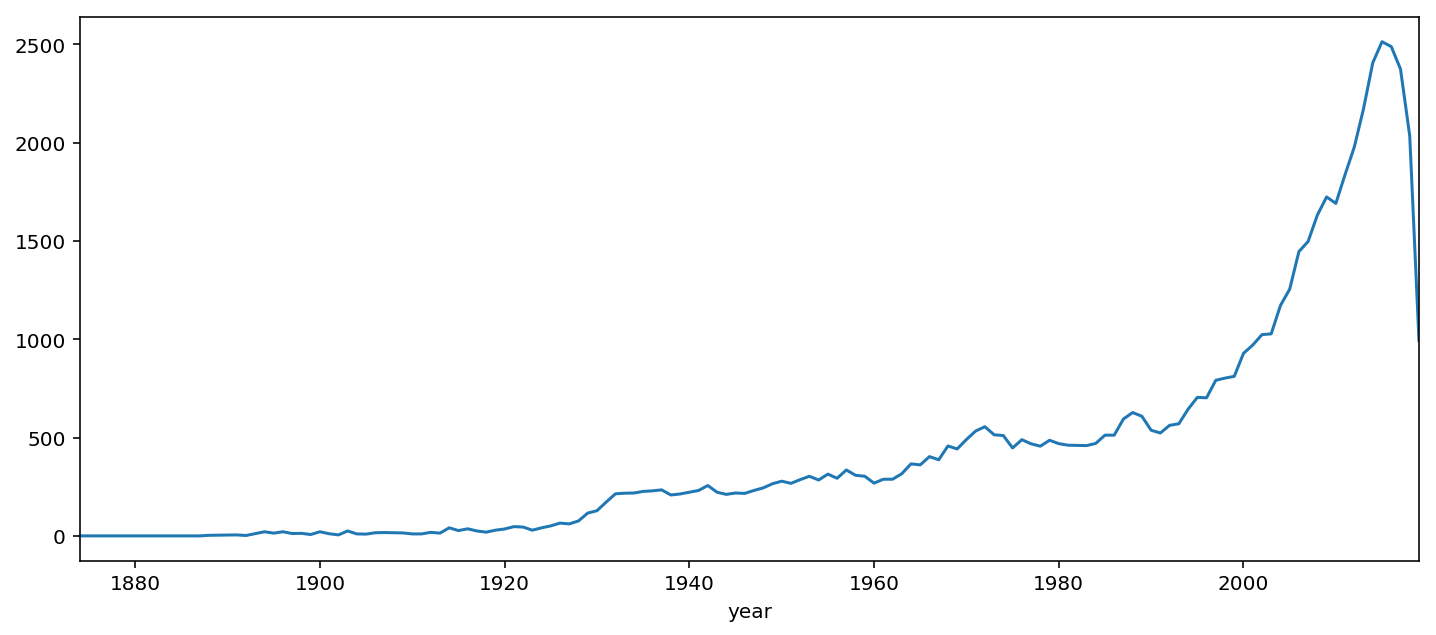

In [18]:
plt.figure(figsize=(12, 5))
relase_count_by_year.set_index('year').sort_index()['count'].plot()
plt.show()

---
## Window Functions

Хотим понять, сколько времени проходит между последовательными оценками для пользователей, более формально:

Для пользователя $u$ есть последовательность $(m_1, r_1, t_1), \ldots, (m_n, r_n, t_n)$, где $t_i \leq t_{i+1}$. Рассмотрим последовательность $\Delta_i = t_{i+1} - t_i$, для $i=1,\ldots,n-1$.

Хотим построить распределение величины $\Delta_i$ используя информацию обо всех пользователях.

In [19]:
from pyspark.sql.window import Window


user_window = Window.orderBy('timestamp').partitionBy('user_id')

ratings_df \
    .withColumn('next_timestamp', F.lead('timestamp').over(user_window)) \
    .filter(F.col('next_timestamp').isNotNull()) \
    .take(10)

[Row(user_id=833, movie_id=7153, rating=1.0, timestamp=1467557005, next_timestamp=1467561775),
 Row(user_id=1342, movie_id=1682, rating=5.0, timestamp=1429639207, next_timestamp=1429642474),
 Row(user_id=1829, movie_id=1569, rating=3.0, timestamp=909017665, next_timestamp=909020025),
 Row(user_id=3794, movie_id=1196, rating=4.0, timestamp=1484585212, next_timestamp=1484595269),
 Row(user_id=5300, movie_id=153, rating=3.0, timestamp=844435558, next_timestamp=844435558),
 Row(user_id=5300, movie_id=344, rating=3.0, timestamp=844435558, next_timestamp=844437310),
 Row(user_id=6357, movie_id=333, rating=2.5, timestamp=1485051413, next_timestamp=1485052289),
 Row(user_id=7253, movie_id=3075, rating=5.0, timestamp=962738980, next_timestamp=962740124),
 Row(user_id=7340, movie_id=3730, rating=5.0, timestamp=1373460027, next_timestamp=1373460350),
 Row(user_id=7340, movie_id=89745, rating=3.5, timestamp=1373460350, next_timestamp=1373461400)]

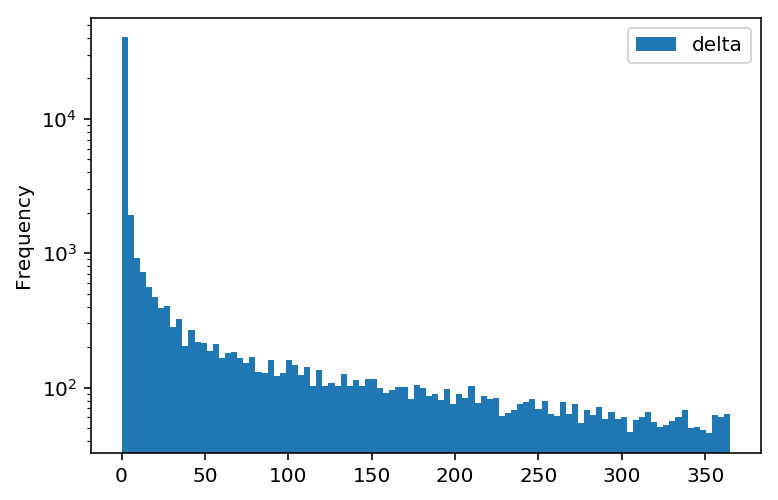

In [20]:
DAY = 24 * 60 * 60

ratings_df \
    .withColumn('next_timestamp', F.lead('timestamp').over(user_window)) \
    .filter(F.col('next_timestamp').isNotNull()) \
    .withColumn('delta', (F.col('next_timestamp') - F.col('timestamp')) / F.lit(DAY)) \
    .select('delta') \
    .filter(F.col('delta') <= 365) \
    .toPandas().plot.hist(bins=100, logy=True)

---
# Упражнения. Recommender System

Пусть $U$ - множество пользователей, $I$ - множество фильмов, и $R = (r_{ui})$ - матрица рейтингов. 

Через $R_u$ будем обозначать строку матрицы $R$, соотвествующую пользователю $u$.

In [21]:
USER_ID = 72315
N = 10

## Evaluation Protocol

Теперь опишем, как будем оценивать качество рассматриваемых методов.

### Data Splits

Так как в данных `ratings` есть поле `timestamp`, то для каждого пользователя отсортируем его рейтинги по времени и первые $80\%$ рейтингов отнесем в `Train`, еще $10\%$ в `Validation`, и остальное в `Test`.

In [22]:
user_window = Window.orderBy('timestamp').partitionBy('user_id')

tiled_ratings_df = ratings_df \
    .withColumn('tile', F.ntile(10).over(user_window)) \

tiled_ratings_df \
    .take(N)

[Row(user_id=148, movie_id=3681, rating=4.0, timestamp=1454942846, tile=1),
 Row(user_id=833, movie_id=7153, rating=1.0, timestamp=1467557005, tile=1),
 Row(user_id=833, movie_id=120466, rating=3.0, timestamp=1467561775, tile=2),
 Row(user_id=1238, movie_id=4226, rating=5.0, timestamp=1495914451, tile=1),
 Row(user_id=1342, movie_id=1682, rating=5.0, timestamp=1429639207, tile=1),
 Row(user_id=1342, movie_id=1245, rating=4.5, timestamp=1429642474, tile=2),
 Row(user_id=1645, movie_id=45, rating=1.0, timestamp=852628572, tile=1),
 Row(user_id=1829, movie_id=1569, rating=3.0, timestamp=909017665, tile=1),
 Row(user_id=1829, movie_id=367, rating=4.0, timestamp=909020025, tile=2),
 Row(user_id=2122, movie_id=1222, rating=4.5, timestamp=1203694373, tile=1)]

In [23]:
train_ratings_df = tiled_ratings_df \
    .filter(F.col('tile') <= 8) \
    .selectExpr('user_id as user_id', 'movie_id as movie_id')
    
train_ratings_df.persist(StorageLevel.DISK_ONLY)

print(train_ratings_df.count())
train_ratings_df \
    .take(N)

123138


[Row(user_id=148, movie_id=3681),
 Row(user_id=833, movie_id=7153),
 Row(user_id=833, movie_id=120466),
 Row(user_id=1238, movie_id=4226),
 Row(user_id=1342, movie_id=1682),
 Row(user_id=1342, movie_id=1245),
 Row(user_id=1645, movie_id=45),
 Row(user_id=1829, movie_id=1569),
 Row(user_id=1829, movie_id=367),
 Row(user_id=2122, movie_id=1222)]

In [24]:
dev_ratings_df = tiled_ratings_df \
    .filter(F.col('tile') == 9) \
    .selectExpr('user_id as user_id', 'movie_id as movie_id')

dev_ratings_df.persist(StorageLevel.DISK_ONLY)

print(dev_ratings_df.count())
dev_ratings_df \
    .take(N)

1085


[Row(user_id=10623, movie_id=185427),
 Row(user_id=29054, movie_id=4619),
 Row(user_id=32855, movie_id=32584),
 Row(user_id=103011, movie_id=6157),
 Row(user_id=112971, movie_id=106916),
 Row(user_id=144475, movie_id=2368),
 Row(user_id=144475, movie_id=31685),
 Row(user_id=19325, movie_id=49815),
 Row(user_id=19886, movie_id=158238),
 Row(user_id=66277, movie_id=3564)]

In [25]:
test_ratings_df = tiled_ratings_df \
    .filter(F.col('tile') == 10) \
    .selectExpr('user_id as user_id', 'movie_id as movie_id')

test_ratings_df.persist(StorageLevel.DISK_ONLY)

print(test_ratings_df.count())
dev_ratings_df \
    .take(N)

805


[Row(user_id=10623, movie_id=185427),
 Row(user_id=29054, movie_id=4619),
 Row(user_id=32855, movie_id=32584),
 Row(user_id=103011, movie_id=6157),
 Row(user_id=112971, movie_id=106916),
 Row(user_id=144475, movie_id=2368),
 Row(user_id=144475, movie_id=31685),
 Row(user_id=19325, movie_id=49815),
 Row(user_id=19886, movie_id=158238),
 Row(user_id=66277, movie_id=3564)]

## Most similar items

Для каждого фильма $i$ определим множество $U(i) = \{ u \in U \mid r_{ui} \neq 0 \}$ - множество пользователей, поставивших фильму $i$ оценку.

Тогда мы можем определить множество $I(i) = \left\{ i' \in I ~\Big|~ sim(i, i') = \frac{|U(i) ~\cap~ U(i')|}{|U(i) ~\cup~ U(i')|} > \delta \right\}$ - множество похожих фильмов.

Можно отсортировать элементы множества $I(i)$ по неубыванию $sim(i, i')$.

Реализуйте функцию, которая на вход получает `movie_id` и возвращает топ `N` фильмов отранжированных по $sim$.

In [26]:
movie_user_set = train_ratings_df \
    .groupBy(F.col('movie_id')) \
    .agg(F.collect_set('user_id').alias('user_set'))

movie_user_set.persist(StorageLevel.DISK_ONLY)

movie_user_set \
    .take(N)

[Row(movie_id=471, user_set=[3937, 142457, 103011, 69474, 57321, 14245, 13868, 66904, 7836, 93930, 111680, 46898, 7634, 122025, 95499, 144282, 23881, 89286, 36454, 113780, 111857, 16884, 65739, 12492, 43852, 67888, 85377, 69030, 123684, 3689, 14186, 30461, 36045, 12997, 9317, 32510, 22399, 123506, 2850, 32998, 73555, 28606, 68002, 159048, 94173, 3047, 21864, 76925, 566, 151922, 66328]),
 Row(movie_id=1088, user_set=[32479, 53300, 41401, 131838, 65612, 75275, 138757, 106432, 14400, 134599, 124480, 45682, 82392, 133527, 40987, 162296, 131314, 15000, 91847, 147700, 116870, 32394, 148789, 20924, 151875, 106062, 35451, 133669, 149008, 21913, 156464, 74674, 78805, 100932, 93913, 54590, 117543, 59200, 112673, 60820, 91571, 15182, 92791, 98142, 134569, 37542, 73469, 112742, 68578, 7193, 133324, 124048, 90830, 123105, 161870, 140601, 127136, 16388, 157348, 149873, 88090, 102303, 75023, 73601, 120961]),
 Row(movie_id=1580, user_set=[15339, 43433, 45153, 92848, 162087, 35094, 58439, 10275, 137616

In [27]:
def get_similarity_score(user_set_0, user_set):
    user_set_0 = set(user_set_0)
    user_set = set(user_set)
    return len(user_set_0.intersection(user_set)) / len(user_set_0.union(user_set))

get_similarity_score_udf = F.udf(get_similarity_score, FloatType())

In [28]:
def get_most_similar_items(movie_id, N):
    delta = 0.0
    return movie_user_set \
        .filter(F.col('movie_id') == movie_id) \
        .selectExpr('movie_id as movie_id_0', 'user_set as user_set_0') \
        .crossJoin(movie_user_set) \
        .withColumn('sim', get_similarity_score_udf('user_set_0', 'user_set')) \
        .filter(F.col('sim') > delta) \
        .select('movie_id', 'sim') \
        .sort(F.col('sim').desc()) \
        .take(N)

In [29]:
get_most_similar_items(movie_id=356, N=N)

[Row(movie_id=356, sim=1.0),
 Row(movie_id=32, sim=0.005847953259944916),
 Row(movie_id=2997, sim=0.005319148767739534),
 Row(movie_id=10, sim=0.005319148767739534),
 Row(movie_id=3996, sim=0.005217391531914473),
 Row(movie_id=367, sim=0.005217391531914473),
 Row(movie_id=1682, sim=0.005172413773834705),
 Row(movie_id=592, sim=0.004622496198862791),
 Row(movie_id=954, sim=0.0044843051582574844),
 Row(movie_id=1254, sim=0.0044742729514837265)]

Построим несколько вариантов простой Рекомендательной Системы.

*Основная цель:* порекомендовать фильм пользователю. (Для простоты опустим информацию о самих рейтингах)

## Methods

При разработке сложных методов, сначала нужно выбрать несколько простых методов (`Baseline`), относительно которых мы будем сравнивать новый метод.

In [30]:
def get_novel_predictions(scoring_fn, user_id, N):
    movies_rated_by_user = train_ratings_df.filter(F.col('user_id') == user_id) \

    return scoring_fn(user_id) \
        .join(movies_rated_by_user, on=['movie_id'], how='left_anti') \
        .selectExpr('movie_id as movie_id', 'score as score') \
        .sort(F.col('score').desc()) \
        .take(N)

### POP

Будем всегда рекомендовать самые популярные фильмы (с наибольшим числом оценок пользователей).

Не смотря на свою простоту, в ряде задач показывает себя достаточно хорошо.

In [31]:
movie_popularity_df = train_ratings_df \
    .groupby('movie_id') \
    .count() \
    .selectExpr('movie_id as movie_id', 'count as count')

movie_popularity_df.persist(StorageLevel.DISK_ONLY)

def score_by_popularity(user_id):
    del user_id

    return movie_popularity_df \
        .selectExpr('movie_id as movie_id', 'count as score')

In [32]:
score_by_popularity(USER_ID) \
    .take(N)

[Row(movie_id=1088, score=65),
 Row(movie_id=471, score=51),
 Row(movie_id=3997, score=11),
 Row(movie_id=1580, score=198),
 Row(movie_id=2366, score=36),
 Row(movie_id=3175, score=75),
 Row(movie_id=44022, score=19),
 Row(movie_id=2142, score=12),
 Row(movie_id=2866, score=14),
 Row(movie_id=8638, score=23)]

In [33]:
get_novel_predictions(score_by_popularity, USER_ID, N)

[Row(movie_id=356, score=419),
 Row(movie_id=296, score=404),
 Row(movie_id=318, score=387),
 Row(movie_id=2571, score=378),
 Row(movie_id=260, score=352),
 Row(movie_id=593, score=341),
 Row(movie_id=480, score=324),
 Row(movie_id=2959, score=311),
 Row(movie_id=527, score=307),
 Row(movie_id=2858, score=298)]

### User-based Collaborative Filtering

1. Для пользователя $u$ определим множество похожих пользователей как 

$$U(u) = \left\{ u' \in U \mid sim(u, u') > \alpha \right\},$$

где $sim(u, u')$ — одна из возможных мер близости $u'$ к $u$, например, косинусная близость между $R_{u}$ и $R_{u'}$

2. $$I(u) = \left\{ i \in I ~\Big|~ B(i) = \frac{|U(u) ~\cap~ U(i)|}{|U(u) ~\cup~ U(i)|} > 0 \right\}$$


3. Отсортировать $i \in I(u)$ по убыванию $B(i)$, взять top $N$

In [34]:
import math

def get_cosine_similarity(movie_set_0, movie_set):
    dot_product = len(set(movie_set_0).intersection(set(movie_set)))
    norm_0 = math.sqrt(len(movie_set_0))
    norm = math.sqrt(len(movie_set))
    return dot_product / (norm_0 * norm)

cosine_similarity_udf = F.udf(get_cosine_similarity, FloatType())

In [35]:
user_movie_set = train_ratings_df \
    .groupBy(F.col('user_id')) \
    .agg(F.collect_set('movie_id').alias('movie_set'))

user_movie_set \
    .take(N)

[Row(user_id=148, movie_set=[3681]),
 Row(user_id=833, movie_set=[120466, 7153]),
 Row(user_id=1238, movie_set=[4226]),
 Row(user_id=1342, movie_set=[1682, 1245]),
 Row(user_id=1645, movie_set=[45]),
 Row(user_id=1829, movie_set=[1569, 367]),
 Row(user_id=2122, movie_set=[1222]),
 Row(user_id=2142, movie_set=[2080]),
 Row(user_id=3794, movie_set=[2953, 1196]),
 Row(user_id=3918, movie_set=[3257])]

In [36]:
def get_similar_users(user_id):
    alpha = 0.1
    return user_movie_set \
        .filter(F.col('user_id') == user_id) \
        .selectExpr('user_id as user_id_0', 'movie_set as movie_set_0') \
        .crossJoin(user_movie_set) \
        .withColumn('sim', cosine_similarity_udf('movie_set_0', 'movie_set')) \
        .filter(F.col('sim') > alpha) \
        .groupby('user_id_0') \
        .agg(F.collect_set('user_id').alias('user_set')) \
        .selectExpr('user_id_0 as user_id', 'user_set as user_set')

In [37]:
get_similar_users(USER_ID) \
    .collect()

[Row(user_id=72315, user_set=[72315])]

In [38]:
def score_by_user_based_collab_filtering(user_id):
    return get_similar_users(user_id) \
        .selectExpr('user_set as user_set_0') \
        .crossJoin(movie_user_set) \
        .withColumn('sim', get_similarity_score_udf('user_set_0', 'user_set')) \
        .filter(F.col('sim') > 0.0) \
        .selectExpr('movie_id as movie_id', 'sim as score')

In [39]:
score_by_user_based_collab_filtering(USER_ID) \
    .take(N)

[Row(movie_id=496, score=1.0),
 Row(movie_id=168316, score=1.0),
 Row(movie_id=2655, score=0.5),
 Row(movie_id=129853, score=1.0),
 Row(movie_id=168168, score=1.0),
 Row(movie_id=131486, score=1.0),
 Row(movie_id=148741, score=1.0),
 Row(movie_id=119860, score=1.0),
 Row(movie_id=211, score=0.25),
 Row(movie_id=152290, score=1.0)]

In [40]:
get_novel_predictions(score_by_user_based_collab_filtering, USER_ID, N)

[]

### Item-kNN

1. Для пользователя $u$ мы знаем $R(u) = \{ i \in I \mid r_{ui} \neq 0 \} $


2. Для каждого $i \in R(u)$ построим $I(i)$ - множество похожих фильмов


3. Отсортируем элементы множества $ \bigcup_{i \in R(u)} I(i) $, возьмем top $N$

In [41]:
def score_by_item_knn(user_id):
    movies_rated_by_user = train_ratings_df \
        .filter(F.col('user_id') == user_id)
    
    user_movies_user_set = get_similar_users(user_id) \
        .join(movies_rated_by_user, 'user_id') \
        .selectExpr('movie_id as movie_id', 'user_set as user_user_set')
    
    delta = 0.0
    nearest_movies_user_sets = user_movies_user_set \
        .join(movie_user_set, ['movie_id']) \
        .selectExpr('movie_id as movie_id_0', 'user_set as user_set_0', 'user_user_set as user_user_set') \
        .crossJoin(movie_user_set) \
        .withColumn('movie_sim', get_similarity_score_udf('user_set_0', 'user_set')) \
        .filter(F.col('movie_sim') > delta) \
        .selectExpr('movie_id as movie_id', 'user_set as movie_user_set', 'user_user_set as user_user_set')
    
    return nearest_movies_user_sets \
        .withColumn('sim', get_similarity_score_udf('movie_user_set', 'user_user_set')) \
        .filter(F.col('sim') > 0.0) \
        .selectExpr('movie_id as movie_id', 'sim as score') \
        .distinct()

In [42]:
score_by_item_knn(USER_ID) \
    .take(N)

[Row(movie_id=129853, score=1.0),
 Row(movie_id=73323, score=0.1111111119389534),
 Row(movie_id=155748, score=1.0),
 Row(movie_id=80162, score=1.0),
 Row(movie_id=1534, score=1.0),
 Row(movie_id=26207, score=1.0),
 Row(movie_id=101233, score=1.0),
 Row(movie_id=151753, score=1.0),
 Row(movie_id=8379, score=0.5),
 Row(movie_id=153764, score=1.0)]

In [43]:
get_novel_predictions(score_by_item_knn, USER_ID, N)

[]

### Metrics

В `Test` для каждого пользователя есть `user_id, R_u`, где $R_u$ - множество фильмов, которым он поставил оценку. Для того чтобы оценить качество рассматриваемых методов будем для пользователя строить список из $N$ рекомендаций $\hat{R}_{1\colon N}$ и считать метрики.

* $$ Precision@N = \frac{|R_u \cap \hat{R}_{1\colon N} |}{N} $$
* $$ Recall@N = \frac{|R_u \cap \hat{R}_{1\colon N} |}{|R_u|} $$
* $Map@N$

где $N \in \{1,5,10\}$

https://spark.apache.org/docs/latest/mllib-evaluation-metrics.html#ranking-systems

In [44]:
test_user_labels = test_ratings_df \
    .groupby('user_id') \
    .agg(F.collect_set('movie_id').alias('labels')) \
    .rdd \
    .collect()

ATS = [1, 5, 10]
MAX_ATS = max(ATS)

def get_predictions_labels(scoring_fn):
    predictions_labels = []
    for row in test_user_labels:
        labels = row.labels
        predictions = get_novel_predictions(scoring_fn, row.user_id, N=MAX_ATS)
        predictions = list(map(lambda row: row.movie_id, predictions))
        print("predictions:", predictions, "labels:", labels)
        predictions_labels.append((predictions, labels))
    return predictions_labels

In [45]:
STARS = 50

In [46]:
# The code is using mllib, but it does not have recall@N or MAP@N, so there is a custom Python code for computing 
# the metrics below. It is acceptable to use Python, since this part is by far the least computation
# intensive in the evaluation process.

from pyspark.mllib.evaluation import RankingMetrics

def evaluate_in_mllib(predictions_labels):
    
    pre_lab_paral = sc.parallelize(predictions_labels)
    ranking_metrics = RankingMetrics(pre_lab_paral)

    print("*" * STARS, "MLLIB", "*" * STARS)
    for N in ATS:
        print("Precision @", N, ranking_metrics.precisionAt(N))
    for N in ATS:
        print("NDCG @", N, ranking_metrics.ndcgAt(N))
    print("MAP", ranking_metrics.meanAveragePrecision)

In [47]:
def evaluate(predictions_labels):

    precisions = []
    recalls = []
    maps = []
    for _ in range(0, MAX_ATS + 1):
        precisions.append([])
        recalls.append([])
        maps.append([])
    
    for predictions, labels in predictions_labels:
        labels_set = set(labels)
        intersections = []
        relevant_up_to_n = 0
        for N in range(1, MAX_ATS + 1):
            intersection_at_n = set(predictions[:N]).intersection(labels_set)
            precisions[N].append(len(intersection_at_n) / N)
            recalls[N].append(len(intersection_at_n) / len(labels_set))
            if N - 1 < len(predictions) and predictions[N - 1] in labels_set:
                relevant_up_to_n += 1
            maps[N].append(relevant_up_to_n / len(labels_set))
        
    print("*" * STARS, "CUSTOM", "*" * STARS)
    for N in ATS:
        print("Precision @", N, np.mean(precisions[N]))
    for N in ATS:
        print("Recall @", N, np.mean(recalls[N]))
    for N in ATS:
        print("MAP @", N, np.mean(maps[N]))

In [48]:
def score_by_true_labels(user_id):
    return test_ratings_df \
        .filter(F.col('user_id') == user_id) \
        .withColumn('is_test', F.lit(1.0)) \
        .selectExpr('movie_id as movie_id', 'is_test as score')

In [49]:
score_by_true_labels(USER_ID) \
    .take(N)

[Row(movie_id=163278, score=1.0),
 Row(movie_id=1613, score=1.0),
 Row(movie_id=153370, score=1.0),
 Row(movie_id=141078, score=1.0),
 Row(movie_id=136768, score=1.0),
 Row(movie_id=205437, score=1.0),
 Row(movie_id=205645, score=1.0),
 Row(movie_id=55659, score=1.0),
 Row(movie_id=6081, score=1.0),
 Row(movie_id=131548, score=1.0)]

In [50]:
%%time
predictions_labels = get_predictions_labels(score_by_true_labels)
evaluate_in_mllib(predictions_labels)
evaluate(predictions_labels)

predictions: [89837] labels: [89837]
predictions: [2200] labels: [2200]
predictions: [6773] labels: [6773]
predictions: [64622] labels: [64622]
predictions: [2501, 2145] labels: [2145, 2501]
predictions: [4175] labels: [4175]
predictions: [3095] labels: [3095]
predictions: [3691] labels: [3691]
predictions: [3988] labels: [3988]
predictions: [5940, 4502, 2081] labels: [2081, 5940, 4502]
predictions: [80980] labels: [80980]
predictions: [7698] labels: [7698]
predictions: [3869, 6265] labels: [3869, 6265]
predictions: [30996] labels: [30996]
predictions: [122904] labels: [122904]
predictions: [193944] labels: [193944]
predictions: [159819] labels: [159819]
predictions: [167834] labels: [167834]
predictions: [5459] labels: [5459]
predictions: [4984] labels: [4984]
predictions: [110453] labels: [110453]
predictions: [6530] labels: [6530]
predictions: [2518] labels: [2518]
predictions: [3916] labels: [3916]
predictions: [3266] labels: [3266]
predictions: [1304] labels: [1304]
predictions: [

predictions: [53349, 4756] labels: [4756, 53349]
predictions: [161658] labels: [161658]
predictions: [158458] labels: [158458]
predictions: [71254, 67009, 77421] labels: [71254, 77421, 67009]
predictions: [31685] labels: [31685]
predictions: [144254] labels: [144254]
predictions: [15] labels: [15]
predictions: [2290] labels: [2290]
predictions: [56805] labels: [56805]
predictions: [179401] labels: [179401]
predictions: [44729] labels: [44729]
predictions: [1972] labels: [1972]
predictions: [31696] labels: [31696]
predictions: [6541] labels: [6541]
predictions: [63121] labels: [63121]
predictions: [1213] labels: [1213]
predictions: [3819] labels: [3819]
predictions: [5049] labels: [5049]
predictions: [88140] labels: [88140]
predictions: [41136] labels: [41136]
predictions: [200824] labels: [200824]
predictions: [74588] labels: [74588]
predictions: [144258] labels: [144258]
predictions: [62792] labels: [62792]
predictions: [52589] labels: [52589]
predictions: [208639] labels: [208639]
pr

predictions: [7756] labels: [7756]
predictions: [6879] labels: [6879]
predictions: [86190, 90281] labels: [86190, 90281]
predictions: [161226] labels: [161226]
predictions: [8464] labels: [8464]
predictions: [2618] labels: [2618]
predictions: [180095] labels: [180095]
predictions: [6862] labels: [6862]
predictions: [6665] labels: [6665]
predictions: [8258] labels: [8258]
predictions: [7020] labels: [7020]
predictions: [4373] labels: [4373]
predictions: [109374] labels: [109374]
predictions: [86781] labels: [86781]
predictions: [2916] labels: [2916]
predictions: [4292] labels: [4292]
predictions: [208082] labels: [208082]
predictions: [4167, 328] labels: [328, 4167]
predictions: [138210] labels: [138210]
predictions: [33808] labels: [33808]
predictions: [153907] labels: [153907]
predictions: [178613] labels: [178613]
predictions: [4180] labels: [4180]
predictions: [115534, 136602] labels: [136602, 115534]
predictions: [308] labels: [308]
predictions: [47518] labels: [47518]
predictions:

predictions: [1909] labels: [1909]
predictions: [103141] labels: [103141]
predictions: [72171, 88235] labels: [88235, 72171]
predictions: [8907] labels: [8907]
predictions: [2858] labels: [2858]
predictions: [2311] labels: [2311]
predictions: [122914] labels: [122914]
predictions: [6458] labels: [6458]
predictions: [2053] labels: [2053]
predictions: [158238] labels: [158238]
predictions: [30816] labels: [30816]
predictions: [192503] labels: [192503]
predictions: [1590] labels: [1590]
predictions: [103141] labels: [103141]
predictions: [126072] labels: [126072]
predictions: [181349] labels: [181349]
predictions: [6880] labels: [6880]
predictions: [200982] labels: [200982]
predictions: [40851] labels: [40851]
predictions: [6196] labels: [6196]
predictions: [3200] labels: [3200]
predictions: [116797] labels: [116797]
predictions: [6441] labels: [6441]
predictions: [45950] labels: [45950]
predictions: [2178] labels: [2178]
predictions: [180031] labels: [180031]
predictions: [6591] labels: 

## Experimental Results

Посмотрим на результаты

*Remark* скорее всего посчитать метрики для всех пользователей будет довольно долго - можно ограничиться, например, случайными 10к пользователями

In [51]:
%%time
predictions_labels = get_predictions_labels(score_by_popularity)
evaluate_in_mllib(predictions_labels)
evaluate(predictions_labels)

predictions: [356, 296, 318, 2571, 260, 593, 480, 2959, 527, 2858] labels: [89837]
predictions: [356, 296, 318, 2571, 260, 593, 480, 2959, 527, 2858] labels: [2200]
predictions: [356, 296, 318, 2571, 260, 593, 480, 2959, 527, 2858] labels: [6773]
predictions: [356, 296, 318, 2571, 260, 593, 480, 2959, 527, 2858] labels: [64622]
predictions: [356, 296, 318, 2571, 260, 593, 480, 2959, 527, 2858] labels: [2145, 2501]
predictions: [356, 296, 318, 2571, 260, 593, 480, 2959, 527, 2858] labels: [4175]
predictions: [356, 296, 318, 2571, 260, 593, 480, 2959, 527, 2858] labels: [3095]
predictions: [356, 296, 318, 2571, 260, 593, 480, 2959, 527, 2858] labels: [3691]
predictions: [356, 296, 318, 2571, 260, 593, 480, 2959, 527, 2858] labels: [3988]
predictions: [356, 296, 318, 2571, 593, 480, 2959, 527, 2858, 110] labels: [2081, 5940, 4502]
predictions: [356, 296, 318, 2571, 260, 593, 480, 2959, 527, 2858] labels: [80980]
predictions: [356, 296, 318, 2571, 260, 593, 480, 2959, 527, 2858] labels: [7

predictions: [356, 296, 318, 2571, 260, 593, 480, 2959, 527, 2858] labels: [7650]
predictions: [356, 296, 318, 2571, 260, 593, 480, 2959, 527, 2858] labels: [5498, 33288]
predictions: [356, 296, 318, 2571, 260, 593, 480, 2959, 527, 2858] labels: [1259]
predictions: [356, 296, 318, 2571, 260, 593, 480, 2959, 527, 2858] labels: [6530]
predictions: [356, 296, 318, 2571, 260, 593, 480, 2959, 527, 2858] labels: [26231]
predictions: [356, 296, 318, 2571, 260, 593, 480, 2959, 527, 2858] labels: [81791]
predictions: [356, 296, 318, 2571, 260, 593, 480, 2959, 527, 2858] labels: [27266]
predictions: [356, 296, 318, 2571, 260, 593, 480, 2959, 527, 2858] labels: [2320]
predictions: [356, 296, 318, 2571, 260, 593, 480, 2959, 527, 2858] labels: [67087]
predictions: [356, 296, 318, 2571, 260, 593, 480, 2959, 527, 2858] labels: [144266]
predictions: [356, 296, 318, 2571, 260, 593, 480, 2959, 527, 2858] labels: [3927]
predictions: [356, 296, 318, 2571, 260, 593, 480, 2959, 527, 2858] labels: [2550]
pre

predictions: [356, 296, 318, 2571, 260, 593, 480, 2959, 527, 2858] labels: [4713]
predictions: [356, 296, 318, 2571, 260, 593, 480, 2959, 527, 2858] labels: [127152, 140525]
predictions: [356, 296, 318, 2571, 260, 593, 480, 2959, 527, 2858] labels: [179819]
predictions: [356, 296, 318, 2571, 260, 593, 480, 2959, 527, 2858] labels: [52265]
predictions: [356, 296, 318, 2571, 260, 593, 480, 2959, 527, 2858] labels: [4631]
predictions: [356, 296, 318, 2571, 260, 593, 480, 2959, 527, 2858] labels: [103772]
predictions: [356, 296, 318, 2571, 260, 593, 2959, 527, 2858, 110] labels: [41997]
predictions: [356, 296, 318, 2571, 260, 593, 480, 2959, 527, 2858] labels: [2238]
predictions: [356, 296, 318, 2571, 260, 593, 480, 2959, 527, 2858] labels: [3355]
predictions: [356, 296, 318, 2571, 260, 593, 480, 2959, 527, 2858] labels: [41566]
predictions: [356, 296, 318, 2571, 260, 593, 480, 2959, 527, 2858] labels: [86835]
predictions: [356, 296, 318, 2571, 260, 593, 480, 2959, 527, 2858] labels: [1840

predictions: [356, 296, 318, 2571, 260, 593, 480, 2959, 527, 2858] labels: [45186]
predictions: [356, 296, 318, 2571, 260, 593, 480, 2959, 527, 2858] labels: [2819]
predictions: [356, 296, 318, 2571, 260, 593, 480, 2959, 527, 2858] labels: [4238]
predictions: [356, 296, 318, 2571, 260, 593, 480, 2959, 527, 2858] labels: [4179]
predictions: [356, 296, 318, 2571, 260, 593, 480, 2959, 527, 2858] labels: [94070]
predictions: [356, 296, 318, 2571, 260, 593, 480, 2959, 527, 2858] labels: [174663]
predictions: [356, 296, 318, 2571, 260, 593, 480, 2959, 527, 2858] labels: [161127]
predictions: [356, 296, 318, 2571, 260, 593, 480, 2959, 527, 2858] labels: [90430]
predictions: [356, 296, 318, 2571, 260, 593, 480, 2959, 527, 2858] labels: [7139]
predictions: [356, 296, 318, 2571, 260, 593, 480, 2959, 527, 2858] labels: [1676]
predictions: [356, 296, 318, 2571, 260, 593, 480, 2959, 527, 2858] labels: [51540]
predictions: [356, 296, 318, 2571, 260, 593, 480, 2959, 527, 2858] labels: [90600]
predict

predictions: [356, 296, 318, 2571, 260, 593, 480, 2959, 527, 2858] labels: [3406]
predictions: [356, 296, 318, 2571, 260, 593, 480, 2959, 527, 2858] labels: [2719]
predictions: [356, 296, 318, 2571, 260, 593, 480, 2959, 527, 2858] labels: [202429, 195163]
predictions: [356, 296, 318, 2571, 260, 593, 480, 2959, 527, 2858] labels: [205809, 168248]
predictions: [356, 296, 318, 2571, 260, 593, 480, 2959, 527, 2858] labels: [119218]
predictions: [356, 296, 318, 2571, 260, 593, 480, 2959, 527, 2858] labels: [44828]
predictions: [356, 296, 318, 2571, 260, 593, 480, 2959, 527, 2858] labels: [162414]
predictions: [356, 296, 318, 2571, 260, 593, 480, 2959, 527, 2858] labels: [92437]
predictions: [356, 296, 318, 2571, 260, 593, 480, 2959, 527, 2858] labels: [596]
predictions: [356, 296, 318, 2571, 260, 593, 480, 2959, 527, 2858] labels: [194448]
predictions: [356, 296, 318, 2571, 260, 593, 480, 2959, 527, 2858] labels: [122882]
predictions: [356, 296, 318, 2571, 260, 593, 480, 2959, 527, 2858] la

predictions: [356, 296, 318, 2571, 260, 593, 480, 2959, 527, 2858] labels: [3637]
predictions: [356, 296, 318, 2571, 260, 593, 480, 2959, 527, 2858] labels: [183869]
predictions: [356, 296, 318, 2571, 260, 593, 480, 2959, 527, 2858] labels: [5026]
predictions: [356, 296, 318, 2571, 260, 593, 480, 2959, 527, 2858] labels: [56775]
predictions: [356, 296, 318, 2571, 260, 593, 480, 2959, 527, 2858] labels: [189241]
predictions: [356, 296, 318, 2571, 260, 593, 480, 2959, 527, 2858] labels: [149352]
predictions: [356, 296, 318, 2571, 260, 593, 480, 2959, 527, 2858] labels: [2672]
predictions: [356, 296, 318, 2571, 260, 593, 480, 2959, 527, 2858] labels: [1009]
predictions: [356, 296, 318, 2571, 260, 593, 480, 2959, 527, 2858] labels: [90057]
predictions: [356, 296, 318, 2571, 260, 593, 480, 2959, 527, 2858] labels: [107141]
predictions: [356, 296, 318, 2571, 260, 593, 480, 2959, 527, 2858] labels: [189203]
predictions: [356, 296, 318, 2571, 260, 593, 480, 2959, 527, 2858] labels: [177883]
pr

predictions: [356, 296, 318, 2571, 260, 593, 480, 2959, 527, 2858] labels: [88454, 174055]
predictions: [356, 296, 318, 2571, 260, 593, 480, 2959, 527, 2858] labels: [202103, 148769]
predictions: [356, 296, 318, 2571, 260, 593, 480, 2959, 527, 2858] labels: [134021]
predictions: [356, 296, 318, 2571, 260, 593, 480, 2959, 527, 2858] labels: [4892]
predictions: [356, 296, 318, 2571, 260, 593, 480, 2959, 527, 2858] labels: [61350]
predictions: [356, 296, 318, 2571, 260, 593, 480, 2959, 527, 2858] labels: [166528]
predictions: [356, 296, 318, 2571, 260, 593, 480, 2959, 527, 2858] labels: [129679]
predictions: [296, 318, 2571, 260, 593, 480, 2959, 527, 2858, 110] labels: [114795]
predictions: [356, 296, 318, 2571, 260, 593, 480, 2959, 527, 2858] labels: [3702]
predictions: [356, 296, 318, 2571, 260, 593, 480, 2959, 527, 2858] labels: [201586]
predictions: [356, 296, 318, 2571, 260, 593, 480, 2959, 527, 2858] labels: [201242]
predictions: [356, 296, 318, 2571, 260, 593, 480, 2959, 527, 2858]

predictions: [356, 296, 318, 2571, 260, 593, 480, 2959, 527, 2858] labels: [99145]
predictions: [356, 296, 318, 2571, 260, 593, 480, 2959, 527, 2858] labels: [185001]
predictions: [356, 296, 318, 2571, 260, 593, 480, 2959, 527, 2858] labels: [1500]
predictions: [356, 296, 318, 2571, 260, 593, 480, 2959, 527, 2858] labels: [115746, 83613]
predictions: [356, 296, 318, 2571, 260, 593, 480, 2959, 527, 2858] labels: [187309]
predictions: [356, 296, 318, 2571, 260, 593, 480, 2959, 527, 2858] labels: [141836]
predictions: [356, 296, 318, 2571, 260, 593, 480, 2959, 527, 110] labels: [165389]
predictions: [356, 296, 318, 2571, 260, 593, 480, 2959, 527, 2858] labels: [3168]
predictions: [356, 296, 318, 2571, 260, 593, 480, 2959, 527, 2858] labels: [165551]
predictions: [356, 296, 318, 2571, 260, 593, 480, 2959, 527, 2858] labels: [203254]
predictions: [356, 296, 318, 2571, 260, 593, 480, 2959, 527, 2858] labels: [1200]
predictions: [356, 296, 318, 260, 593, 480, 2959, 527, 2858, 110] labels: [14

In [52]:
%%time
predictions_labels = get_predictions_labels(score_by_user_based_collab_filtering)
evaluate_in_mllib(predictions_labels)
evaluate(predictions_labels)

predictions: [72998, 1688, 97921, 319, 3911, 6539, 73017, 2671, 1259, 750] labels: [89837]
predictions: [6183, 678, 6401, 144262, 31270, 54220, 94558, 5020, 3331, 81736] labels: [2200]
predictions: [2396, 3525, 5693, 2688, 3108, 4816, 1097, 2467, 1367, 1597] labels: [6773]
predictions: [1556, 7153, 5378, 5152, 64969, 5225, 2539, 1372, 370, 899] labels: [64622]
predictions: [5299, 374, 1673, 2959, 82378, 33722, 7224, 5236, 103661, 184253] labels: [2145, 2501]
predictions: [539, 1265, 8641, 785, 1376, 92259, 104841, 2640, 2395, 1270] labels: [4175]
predictions: [5989, 6373, 34319, 1287, 70, 69844, 1148, 8665, 2571, 296] labels: [3095]
predictions: [3019, 3697, 3825, 1274, 377, 2294, 1947, 4848, 160, 4979] labels: [3691]
predictions: [2009, 5875, 69469, 151703, 137337, 6471, 4493, 44729, 47150, 48879] labels: [3988]
predictions: [2542, 1219, 1682, 1291, 5872, 1722, 6870, 899, 3052, 2194] labels: [2081, 5940, 4502]
predictions: [4701, 112183, 2710, 1968, 110882, 4612, 44761, 3477, 3684, 55

predictions: [2424, 1265, 8874, 1917, 1208, 33794, 3996, 1682, 441, 364] labels: [51082]
predictions: [1307, 1036, 4306, 3578, 111, 260, 34, 1291, 67734, 2096] labels: [105844]
predictions: [81591, 1207, 4027, 1208, 4963, 60069, 33669, 2924, 59501, 45728] labels: [1217]
predictions: [7153, 67923, 69406, 7099, 60040, 5673, 1499, 3827, 1240, 8361] labels: [144734, 160567, 127208]
predictions: [1219, 1206, 3481, 1784, 2381, 1200, 8907, 97923, 4844, 412] labels: [3623]
predictions: [2712, 2471, 4855, 186, 2455, 45447, 3863, 8784, 68237, 134853] labels: [126044]
predictions: [778, 5459, 44191, 344, 2762, 3578, 5952, 527, 231, 6874] labels: [186631]
predictions: [163, 1197, 3527, 5956, 34162, 3418, 2712, 2916, 48516, 736] labels: [139385]
predictions: [6287, 59369, 91658, 5971, 19, 2916, 48516, 1721, 541, 7256] labels: [7650]
predictions: [367, 551, 5620, 3034, 33004, 1953, 8361, 552, 5956, 216] labels: [5498, 33288]
predictions: [8984, 32587, 3439, 71379, 7454, 293, 87232, 122892, 673, 1090

predictions: [4865, 3100, 1645, 3497, 3096, 1734, 3946, 1961, 1888, 3098] labels: [7149]
predictions: [2001, 2997, 5971, 5669, 104, 5349, 1721, 2716, 46970, 3741] labels: [85394]
predictions: [2424, 173, 1625, 40815, 356, 223, 919, 4741, 1136, 5094] labels: [2942]
predictions: [101864, 2004, 2707, 8622, 2890, 3253, 2424, 4848, 1270, 2115] labels: [71205]
predictions: [3996, 1246, 1206, 1200, 1221, 380, 150, 780, 405, 589] labels: [1552]
predictions: [1921, 102445, 1215, 59260, 26746, 120315, 26237, 30712, 8402, 26249] labels: [53953]
predictions: [3977, 1345, 122912, 3363, 616, 745, 1552, 3578, 2890, 3052] labels: [318]
predictions: [3545, 3039, 552, 8622, 1285, 3623, 17, 3977, 1219, 597] labels: [5247]
predictions: [1282, 68073, 3068, 1422, 1888, 1028, 1358, 2395, 3756, 3716] labels: [1355]
predictions: [1882, 1127, 4855, 2890, 1562, 923, 4027, 1073, 166558, 932] labels: [7000]
predictions: [7361, 541, 2762, 2706, 6754, 56782, 47, 70, 923, 1610] labels: [46972]
predictions: [367, 3033

predictions: [6377, 1438, 196, 5956, 122882, 1777, 1544, 1387, 593, 8961] labels: [177237, 183611]
predictions: [6934, 1097, 3267, 3157, 1690, 6870, 805, 1088, 3471, 71535] labels: [164823]
predictions: [4979, 4011, 231, 5349, 1380, 3948, 2291, 349, 1221, 58559] labels: [1465]
predictions: [593, 10, 318, 32, 1270, 2329, 2997, 1580, 380, 47] labels: [167570]
predictions: [4993, 1387, 54272, 1370, 1127, 5952, 1270, 48780, 5349, 4226] labels: [6534]
predictions: [595, 2701, 1210, 32, 1080, 588, 54259, 3300, 2699, 1376] labels: [996]
predictions: [475, 2858, 6979, 3246, 215, 2908, 2021, 1261, 4310, 1320] labels: [189191]
predictions: [2797, 4995, 1291, 2396, 1682, 1965, 1587, 193, 5952, 2455] labels: [5021]
predictions: [3997, 3298, 27660, 1077, 2953, 122892, 293, 6373, 1997, 5502] labels: [1295]
predictions: [2791, 2291, 1381, 4545, 112623, 33794, 548, 207, 18, 7445] labels: [134095]
predictions: [156387, 94780, 71530, 37741, 419, 86880, 1961, 61240, 60040, 4361] labels: [171491]
predicti

predictions: [2700, 1291, 296, 3617, 1722, 32, 231, 1240, 608, 5952] labels: [4091]
predictions: [3052, 2167, 110, 2858, 1485, 5378, 2628, 1213, 2716, 377] labels: [947]
predictions: [318, 457, 2706, 1291, 1210, 5952, 527, 4963, 356, 1265] labels: [8972]
predictions: [2529, 3052, 2617, 1954, 908, 1584, 593, 2683, 185, 208] labels: [91529]
predictions: [34162, 5378, 329, 5267, 8645, 37733, 135143, 648, 31685, 2058] labels: [51084]
predictions: [3477, 471, 69844, 764, 99919, 988, 58964, 7708, 7005, 25993] labels: [123178]
predictions: [1994, 76251, 3108, 8984, 2657, 47610, 7, 1266, 62, 2710] labels: [8783]
predictions: [6947, 6808, 102481, 1931, 5690, 58803, 93840, 4007, 2393, 1172] labels: [166705]
predictions: [8361, 594, 1126, 942, 3198, 3173, 67255, 5388, 8917, 6787] labels: [5528]
predictions: [111781, 97938, 4270, 1884, 1258, 198185, 71464, 4386, 48082, 56152] labels: [56152]
predictions: [837, 524, 1562, 1954, 908, 8874, 1682, 257, 2497, 4054] labels: [1305]
predictions: [595, 119

predictions: [8014, 54648, 130490, 53123, 53519, 63131, 3060, 8917, 53000, 98809] labels: [95088]
predictions: [126, 2990, 79695, 5449, 3263, 88810, 1961, 164, 800, 1682] labels: [48744]
predictions: [2712, 8874, 110, 344, 1265, 377, 58293, 3698, 589, 186] labels: [8604]
predictions: [1722, 1247, 1923, 1, 80917, 3147, 1974, 2991, 103253, 1256] labels: [3075]
predictions: [1210, 2959, 1240, 2402, 2662, 1249, 849, 2021, 914, 471] labels: [26133]
predictions: [3052, 223, 1917, 2688, 3247, 2694, 5459, 49272, 1246, 1080] labels: [79720]
predictions: [3538, 3334, 2474, 1277, 8983, 3593, 4855, 1020, 6947, 2021] labels: [6562]
predictions: [4031, 2706, 100383, 33834, 8366, 2474, 69526, 3706, 6323, 54995] labels: [3735]
predictions: [3081, 367, 1200, 1991, 3684, 76, 2409, 4489, 51540, 80489] labels: [98585]
predictions: [1179, 474, 551, 1917, 7438, 1097, 4537, 5237, 6650, 949] labels: [1321]
predictions: [2987, 1222, 2363, 6440, 674, 3697, 230, 2944, 45720, 8641] labels: [34162]
predictions: [3

predictions: [3253, 2617, 442, 2012, 366, 1961, 3258, 8961, 517, 1091] labels: [72762]
predictions: [32, 1968, 589, 185, 165, 733, 4995, 174, 1580, 1974] labels: [200838]
predictions: [1093, 6534, 5464, 541, 4447, 2167, 2762, 2395, 56367, 329] labels: [85790]
predictions: [908, 296, 4993, 6863, 1580, 3155, 1965, 32, 148626, 198] labels: [8290]
predictions: [6378, 520, 1544, 1090, 356, 8644, 141, 223, 21, 1225] labels: [95105]
predictions: [2871, 2294, 1729, 5502, 2165, 7235, 4383, 51080, 30822, 8366] labels: [79796]
predictions: [46972, 2706, 3752, 3785, 923, 5426, 72672, 94931, 181567, 154358] labels: [104337]
predictions: [1080, 342, 1278, 480, 1246, 438, 163134, 51412, 2719, 5009] labels: [56171]
predictions: [140956, 140110, 55290, 91630, 1282, 315, 4014, 82765, 8802, 146196] labels: [183869]
predictions: [6016, 72998, 122884, 2422, 507, 3504, 915, 5219, 2908, 1036] labels: [69844]
predictions: [1805, 367, 5481, 3835, 2120, 2668, 2642, 3543, 4973, 3869] labels: [1947]
predictions: 

predictions: [3948, 94777, 53996, 56174, 4979, 551, 1580, 187593, 5419, 4084] labels: [158872]
predictions: [2918, 5266, 5956, 2617, 4993, 5349, 60069, 2052, 56156, 48997] labels: [3535]
predictions: [5952, 2571, 778, 6377, 780, 32, 54272, 5971, 134853, 1233] labels: [143355]
predictions: [2819, 1958, 8810, 800, 122912, 5225, 85414, 673, 2406, 2193] labels: [3966]
predictions: [318, 1374, 1, 1957, 3702, 1088, 3421, 112852, 923, 2858] labels: [1909]
predictions: [49272, 134130, 356, 1198, 1784, 6365, 919, 1704, 141866, 6753] labels: [103141]
predictions: [3897, 1136, 1210, 357, 1580, 6539, 364, 1270, 1261, 1047] labels: [88235, 72171]
predictions: [356, 778, 2571, 344, 1580, 3578, 780, 1210, 858, 2002] labels: [8907]
predictions: [551, 4558, 4623, 921, 2404, 1015, 1095, 3438, 1831, 2872] labels: [2858]
predictions: [247, 6373, 778, 3996, 3307, 2423, 3510, 1580, 3755, 8361] labels: [2311]
predictions: [5989, 1206, 111364, 114662, 2413, 60074, 1371, 1287, 2076, 2455] labels: [122914]
pred

In [53]:
%%time
predictions_labels = get_predictions_labels(score_by_item_knn)
evaluate_in_mllib(predictions_labels)
evaluate(predictions_labels)

predictions: [72998, 1688, 97921, 319, 3911, 6539, 73017, 2671, 1259, 750] labels: [89837]
predictions: [6183, 678, 5567, 81736, 94558, 31270, 54220, 3331, 5020, 144262] labels: [2200]
predictions: [2396, 3525, 5693, 2688, 3108, 4816, 1097, 2467, 1367, 1597] labels: [6773]
predictions: [1556, 7153, 5378, 5152, 64969, 5225, 2539, 1372, 370, 899] labels: [64622]
predictions: [5299, 374, 1673, 2959, 82378, 7224, 103661, 33722, 5236, 49132] labels: [2145, 2501]
predictions: [539, 1265, 8641, 785, 1376, 92259, 104841, 2640, 2395, 1270] labels: [4175]
predictions: [5989, 6373, 34319, 1287, 70, 69844, 8665, 1148, 2571, 296] labels: [3095]
predictions: [3019, 3697, 3825, 1274, 377, 2294, 1947, 4848, 160, 4979] labels: [3691]
predictions: [2009, 44729, 69469, 151703, 6471, 48879, 8831, 4493, 5875, 47150] labels: [3988]
predictions: [2542, 1219, 1682, 1291, 5872, 1722, 6870, 899, 3052, 2194] labels: [2081, 5940, 4502]
predictions: [4701, 112183, 2710, 1968, 110882, 4612, 44761, 3477, 3684, 55052

predictions: [2424, 1265, 8874, 1917, 1208, 33794, 3996, 1682, 441, 364] labels: [51082]
predictions: [1307, 1036, 4306, 3578, 111, 260, 34, 1291, 67734, 2096] labels: [105844]
predictions: [81591, 1207, 4027, 1208, 4963, 60069, 33669, 2924, 59501, 45728] labels: [1217]
predictions: [7153, 67923, 69406, 7099, 60040, 5673, 1499, 3827, 1240, 8361] labels: [144734, 160567, 127208]
predictions: [1219, 1206, 3481, 1784, 2381, 1200, 8907, 97923, 4844, 2243] labels: [3623]
predictions: [2712, 2471, 4855, 186, 2455, 45447, 3863, 68237, 8784, 134853] labels: [126044]
predictions: [778, 5459, 44191, 344, 2762, 3578, 5952, 527, 231, 6874] labels: [186631]
predictions: [163, 1197, 3527, 5956, 34162, 3418, 2712, 2916, 48516, 736] labels: [139385]
predictions: [6287, 59369, 91658, 5971, 19, 2916, 48516, 1721, 541, 7256] labels: [7650]
predictions: [367, 551, 5620, 3034, 33004, 1953, 552, 8361, 5956, 216] labels: [5498, 33288]
predictions: [8984, 32587, 3439, 71379, 7454, 293, 87232, 122892, 673, 109

predictions: [4865, 3100, 1645, 3497, 3096, 3946, 1734, 1961, 1888, 3098] labels: [7149]
predictions: [2001, 2997, 5971, 5669, 104, 5349, 1721, 2716, 46970, 3741] labels: [85394]
predictions: [2424, 173, 1625, 40815, 356, 223, 919, 4741, 1136, 5094] labels: [2942]
predictions: [101864, 2004, 2707, 8622, 2890, 3253, 2424, 4848, 1270, 2115] labels: [71205]
predictions: [3996, 1246, 1206, 1200, 1221, 380, 150, 780, 405, 589] labels: [1552]
predictions: [1921, 102445, 1215, 26237, 59260, 204648, 55955, 26249, 30712, 26746] labels: [53953]
predictions: [3977, 1345, 122912, 3363, 616, 745, 1552, 3578, 2890, 3052] labels: [318]
predictions: [3545, 3039, 552, 8622, 1285, 3623, 17, 3977, 1219, 597] labels: [5247]
predictions: [1282, 68073, 1422, 3068, 1888, 1028, 1358, 2395, 3756, 141830] labels: [1355]
predictions: [1882, 1127, 4855, 2890, 1562, 923, 4027, 1073, 166558, 932] labels: [7000]
predictions: [7361, 541, 2762, 2706, 6754, 56782, 47, 70, 923, 1610] labels: [46972]
predictions: [367, 3

predictions: [6377, 1438, 196, 5956, 122882, 1777, 1544, 1387, 593, 8961] labels: [177237, 183611]
predictions: [6934, 1097, 3267, 3157, 1690, 6870, 805, 1088, 3471, 71535] labels: [164823]
predictions: [4979, 4011, 5349, 231, 1380, 3948, 2291, 349, 1221, 58559] labels: [1465]
predictions: [593, 10, 318, 32, 1270, 2329, 2997, 1580, 380, 47] labels: [167570]
predictions: [4993, 1387, 54272, 1370, 1127, 5952, 1270, 48780, 5349, 4226] labels: [6534]
predictions: [595, 2701, 1210, 32, 1080, 588, 54259, 3300, 2699, 1376] labels: [996]
predictions: [475, 2858, 6979, 215, 3246, 2908, 2021, 1261, 4310, 1320] labels: [189191]
predictions: [2797, 4995, 1291, 2396, 1682, 1965, 1587, 193, 5952, 2455] labels: [5021]
predictions: [3997, 3298, 27660, 1077, 2953, 293, 122892, 6373, 1997, 5502] labels: [1295]
predictions: [2791, 2291, 1381, 4545, 112623, 33794, 548, 207, 18, 7445] labels: [134095]
predictions: [156387, 94780, 71530, 37741, 419, 86880, 1961, 61240, 60040, 102125] labels: [171491]
predic

predictions: [2700, 1291, 296, 3617, 1722, 32, 231, 1240, 608, 5952] labels: [4091]
predictions: [3052, 2167, 110, 2858, 1485, 5378, 2628, 1213, 2716, 377] labels: [947]
predictions: [318, 457, 2706, 1291, 1210, 5952, 527, 4963, 356, 1265] labels: [8972]
predictions: [2529, 3052, 2617, 1954, 908, 1584, 593, 2683, 185, 208] labels: [91529]
predictions: [34162, 5378, 329, 5267, 8645, 37733, 135143, 648, 31685, 2058] labels: [51084]
predictions: [3477, 471, 69844, 764, 988, 7708, 58964, 99919, 26694, 49263] labels: [123178]
predictions: [1994, 76251, 3108, 8984, 2657, 47610, 7, 1266, 62, 2710] labels: [8783]
predictions: [6947, 6808, 102481, 1931, 5690, 58803, 93840, 4007, 2393, 44199] labels: [166705]
predictions: [8361, 594, 1126, 942, 3198, 3173, 5388, 67255, 8917, 6787] labels: [5528]
predictions: [111781, 97938, 4270, 1884, 1258, 198185, 71464, 4386, 48082, 4128] labels: [56152]
predictions: [837, 524, 1562, 1954, 908, 8874, 1682, 257, 2497, 4054] labels: [1305]
predictions: [595, 11

predictions: [8014, 54648, 130490, 53123, 53519, 63131, 3060, 8917, 53000, 98809] labels: [95088]
predictions: [126, 2990, 79695, 5449, 3263, 1961, 88810, 164, 800, 1682] labels: [48744]
predictions: [2712, 8874, 110, 344, 1265, 377, 58293, 3698, 589, 186] labels: [8604]
predictions: [1722, 1247, 1923, 1, 80917, 3147, 1974, 2991, 103253, 1256] labels: [3075]
predictions: [1210, 2959, 1240, 2402, 2662, 1249, 849, 2021, 914, 471] labels: [26133]
predictions: [3052, 223, 1917, 2688, 3247, 2694, 5459, 49272, 1246, 1080] labels: [79720]
predictions: [3538, 3334, 2474, 1277, 8983, 3593, 4855, 1020, 6947, 2021] labels: [6562]
predictions: [4031, 2706, 100383, 33834, 8366, 2474, 69526, 3706, 54995, 6323] labels: [3735]
predictions: [3081, 367, 1200, 1991, 3684, 76, 2409, 4489, 51540, 3157] labels: [98585]
predictions: [1179, 474, 551, 1917, 7438, 1097, 4537, 6650, 5237, 949] labels: [1321]
predictions: [2987, 1222, 2363, 6440, 674, 3697, 230, 2944, 45720, 8641] labels: [34162]
predictions: [30

predictions: [3253, 2617, 442, 2012, 366, 1961, 3258, 8961, 517, 1091] labels: [72762]
predictions: [32, 1968, 589, 185, 165, 733, 4995, 174, 1580, 1974] labels: [200838]
predictions: [1093, 6534, 5464, 541, 4447, 2167, 2762, 56367, 2395, 329] labels: [85790]
predictions: [908, 296, 4993, 6863, 1580, 3155, 1965, 32, 148626, 198] labels: [8290]
predictions: [6378, 520, 1544, 1090, 356, 8644, 141, 223, 21, 1225] labels: [95105]
predictions: [2871, 2294, 1729, 5502, 2165, 7235, 30822, 4383, 51080, 8366] labels: [79796]
predictions: [46972, 2706, 3752, 3785, 923, 92335, 172881, 94931, 91048, 5426] labels: [104337]
predictions: [1080, 342, 1278, 480, 1246, 438, 163134, 51412, 2719, 5009] labels: [56171]
predictions: [140956, 140110, 55290, 91630, 1282, 315, 4014, 82765, 122523, 8802] labels: [183869]
predictions: [6016, 72998, 122884, 2422, 507, 3504, 915, 5219, 2908, 1036] labels: [69844]
predictions: [1805, 367, 5481, 3835, 2120, 2668, 2642, 3543, 4973, 3869] labels: [1947]
predictions: [

predictions: [3948, 94777, 53996, 56174, 4979, 551, 1580, 187593, 5419, 4084] labels: [158872]
predictions: [2918, 5266, 5956, 2617, 4993, 5349, 60069, 2052, 56156, 48997] labels: [3535]
predictions: [5952, 2571, 778, 6377, 780, 32, 54272, 5971, 134853, 1233] labels: [143355]
predictions: [2819, 1958, 8810, 800, 122912, 5225, 85414, 673, 2406, 2193] labels: [3966]
predictions: [318, 1374, 1, 1957, 3702, 1088, 3421, 112852, 923, 2858] labels: [1909]
predictions: [49272, 134130, 356, 1198, 1784, 6365, 919, 1704, 141866, 6753] labels: [103141]
predictions: [3897, 1136, 1210, 357, 1580, 6539, 364, 1270, 1261, 1047] labels: [88235, 72171]
predictions: [356, 778, 2571, 344, 1580, 3578, 780, 1210, 2002, 858] labels: [8907]
predictions: [551, 4558, 4623, 921, 2404, 1015, 1095, 3438, 1831, 2872] labels: [2858]
predictions: [247, 6373, 778, 3996, 3307, 2423, 3510, 1580, 3755, 8361] labels: [2311]
predictions: [5989, 1206, 111364, 114662, 2413, 60074, 1371, 1287, 2076, 2455] labels: [122914]
pred

## Performance Analysis

|----------------------------------------------------------------------------------------------|

|Data split	| Novel	| Caching | True labels | Popular | User-based Collab | Item-kNN |

|----------------------------------------------------------------------|

|0.001 (25060|9|4) | false | no | 2.99 s | 17.7 s | 43 s | 1min 11s |

|--------------------------------------------------------------------------|

|0.001 (25060|9|4) | false | manual | 1.38 s | 7.82 s | 34.1 s | 50.2 s |

|-----------------------------------------------------------------------|

|0.001 (25060|9|4) | true | manual | 6.05 s | 12.8 s | 37 s | 51.2 s |

|--------------------------------------------------------------------------|

|0.001 (25060|9|4) | true | DISK_ONLY | 3.55 s | 3.71 s | 24.6 s | 31.6 s |

|--------------------------------------------------------------------------|

| 0.002 (49827|76|53) | true | DISK_ONLY | 46.6 s | 43.8 s | 6min 10s | 9min 12s |

|----------------------------------------------------------------------------------|

|0.005 (123138|1085|805) | true | DISK_ONLY | 12min 17s | 11min 16s | 1h 48min 19s | 3h 34min 33s |

|----------------------------------------------------------------------------------|